In [1]:
import numpy as np #Import relevant packages
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import glob
import csv
import matplotlib.pyplot as plt

In [2]:
def unpack_data(filepath): #Returns a dictionary where each item is a df containing one run. One dict per generation.
    all_files = glob.glob(filepath + "/*.csv")
    name_list = []
    datadict = {}
    for f in all_files:
        name_list.append(f[77:-4])
    for i,n in enumerate(name_list):
        datadict[n] = pd.read_csv(all_files[i], header=0)
    for k, v in datadict.items():
        v.drop(columns=["Unnamed: 0", "volume", "spread", "10_MA", "50_MA"], inplace=True)
    return datadict

def format_data(datadict, window): #Turn dictionaries of data into features and samples lists
    x_data = []
    y_data = []
    for k, v in datadict.items():
        for i in range(len(v)):
            if i >= window:
                y_data.append(v.iloc[i]["trading_price"])
                xi = v.iloc[i-window:i].to_numpy()
                x_data.append(xi)
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    y_data = np.reshape(y_data, (y_data.shape[0], 1))
    return x_data, y_data

def normalise_data(xarray, yarray): #Take the natural log and then normalise prices
    yarray_log = np.log(yarray)
    xarray_log = np.log(xarray)
    xsc = StandardScaler()
    instances, timesteps, features = xarray_log.shape
    xarray_log = np.reshape(xarray_log, (-1, features))
    xarray_norm = xsc.fit_transform(xarray_log)
    xarray_norm = np.reshape(xarray_norm, (instances, timesteps, features))
    ysc = StandardScaler().fit(yarray_log)
    yarray_norm = ysc.transform(yarray_log)
    return xarray_norm, yarray_norm, xsc, ysc

def split_data(xarray, yarray, trainratio): #Split the data into training and test sets
    train_len = int(len(xarray)*trainratio)
    test_len = len(xarray) - train_len
    x_train, y_train, x_test, y_test = xarray[:train_len], yarray[:train_len], xarray[train_len:], yarray[train_len:]
    return x_train, y_train, x_test, y_test

In [3]:
gen7 = unpack_data("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen7_sims/data")

In [4]:
X8, y8 = format_data(gen7, 20)
print(X8.shape)
print(y8.shape)

(30979, 20, 2)
(30979, 1)


In [5]:
X8_train, y8_train, X8_test, y8_test = split_data(X8, y8, 0.8)

In [6]:
X8_train, y8_train, X8scale, y8scale = normalise_data(X8_train, y8_train)
X8_test, y8_test, _, _ = normalise_data(X8_test, y8_test)

In [7]:
print(X8scale.mean_)
print(X8scale.var_)
print(y8scale.mean_)
print(y8scale.var_)
print(X8_train)
print(y8_train)

[4.74162543 4.79828351]
[0.0682162  0.01660693]
[4.74761886]
[0.07466366]
[[[-0.52245207 -1.49853733]
  [-0.48549223 -1.49310731]
  [-0.48700931 -1.48535673]
  ...
  [-0.36640019 -1.25561527]
  [-0.36309337 -1.24509339]
  [-0.36272612 -1.23758648]]

 [[-0.48549223 -1.49310731]
  [-0.48700931 -1.48535673]
  [-0.48018716 -1.47761387]
  ...
  [-0.36309337 -1.24509339]
  [-0.36272612 -1.23758648]
  [-0.36713542 -1.21361308]]

 [[-0.48700931 -1.48535673]
  [-0.48018716 -1.47761387]
  [-0.47262122 -1.46678684]
  ...
  [-0.36272612 -1.23758648]
  [-0.36713542 -1.21361308]
  [-0.34185101 -1.20613655]]

 ...

 [[-1.76376027 -0.16238552]
  [-1.75582615 -0.15455055]
  [-1.80314441 -0.14672348]
  ...
  [-2.3164658   0.01648559]
  [-2.36200266  0.03688622]
  [-2.3980762   0.04452265]]

 [[-1.75582615 -0.15455055]
  [-1.80314441 -0.14672348]
  [-1.77011943 -0.1070575 ]
  ...
  [-2.36200266  0.03688622]
  [-2.3980762   0.04452265]
  [-2.45790645  0.05215157]]

 [[-1.80314441 -0.14672348]
  [-1.770119

In [8]:
lstm8=keras.Sequential() #Set up the architecture of the model

lstm8.add(layers.LSTM(units=16, input_shape=(X8_train.shape[1], X8_train.shape[2])))
lstm8.add(layers.Dropout(0.2))

lstm8.add(layers.Dense(units=1))

print(lstm8.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 16)                1216      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 1,233
Trainable params: 1,233
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
lstm8.compile(optimizer='nadam', loss='mean_squared_error') #Compile and train the model

history8 = lstm8.fit(X8_train, y8_train, epochs = 10, batch_size = 32, validation_split=0.2, shuffle=False)

Train on 19826 samples, validate on 4957 samples
Epoch 1/10
19826/19826 [==============================] - 33s 2ms/sample - loss: 0.2881 - val_loss: 0.5098
Epoch 2/10
19826/19826 [==============================] - 26s 1ms/sample - loss: 0.0707 - val_loss: 0.1841
Epoch 3/10
19826/19826 [==============================] - 24s 1ms/sample - loss: 0.0308 - val_loss: 0.0873
Epoch 4/10
19826/19826 [==============================] - 25s 1ms/sample - loss: 0.0232 - val_loss: 0.0443
Epoch 5/10
19826/19826 [==============================] - 23s 1ms/sample - loss: 0.0215 - val_loss: 0.0209
Epoch 6/10
19826/19826 [==============================] - 27s 1ms/sample - loss: 0.0194 - val_loss: 0.0141
Epoch 7/10
19826/19826 [==============================] - 25s 1ms/sample - loss: 0.0184 - val_loss: 0.0113
Epoch 8/10
19826/19826 [==============================] - 24s 1ms/sample - loss: 0.0194 - val_loss: 0.0407
Epoch 9/10
19826/19826 [==============================] - 23s 1ms/sample - loss: 0.0213 - val_l

In [10]:
lstm8.save("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm8")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm8/assets


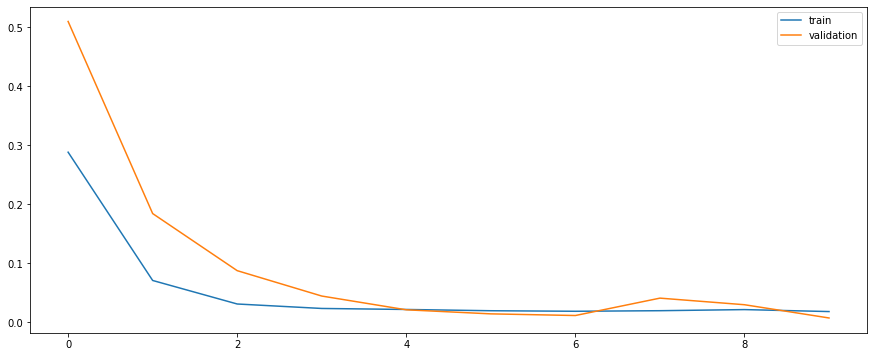

In [11]:
plt.figure(figsize=(15,6))
plt.plot(history8.history["loss"], label="train")
plt.plot(history8.history["val_loss"], label="validation")
plt.legend()

In [12]:
y8_pred = lstm8.predict(X8_test)
y8_train_inv = y8scale.inverse_transform(y8_train.reshape(1, -1))
y8_test_inv = y8scale.inverse_transform(y8_test.reshape(1, -1))
y8_pred_inv  = y8scale.inverse_transform(y8_pred)

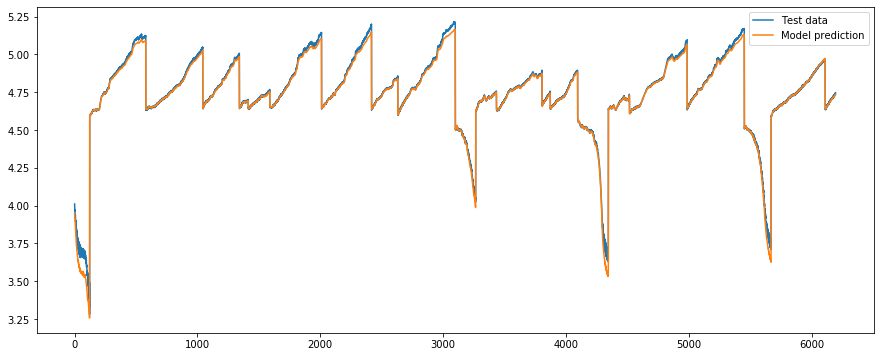

In [13]:
plt.figure(figsize=(15,6))
plt.plot(y8_test_inv.flatten(), label="Test data")
plt.plot(y8_pred_inv.flatten(), label="Model prediction")
plt.legend()